In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import re
import torch
import warnings
import logging

from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_scheduler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from tqdm import tqdm

!pip install ipywidgets==8.1.5

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category = UserWarning)

loggers = [logging.getLogger(name) for name in logging.root.manager.loggerDict]
for logger in loggers:
    if "transformers" in logger.name.lower():
        logger.setLevel(logging.ERROR)

train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
kaggle_test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

print("\nBelow is the training data:\n")
train_df

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 40.1 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.8
    Uninstalling widgetsnbextension-3.6.8:
      Successfully uninstalled widgetsnbextension-3.6.8
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab_widgets 3.0.11
    Uninstalling jupyterlab_widgets-3.0.11:
      Successfully uninstalled jupyterlab_widgets-3.0.11
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.22.0 

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1



1743 tweets in the training data contain hashtag

3971 tweets in the training data contain URL

2009 tweets in the training data contain mentions


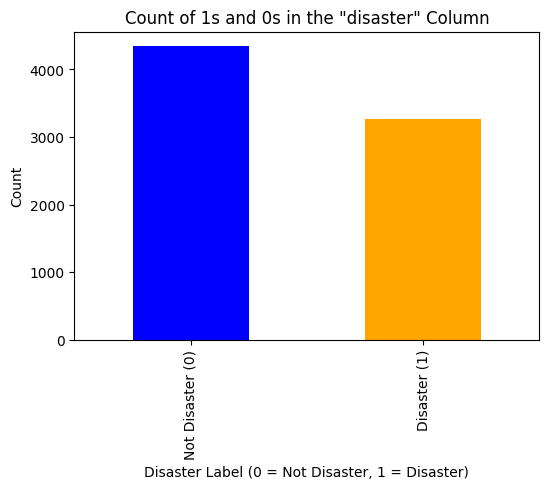

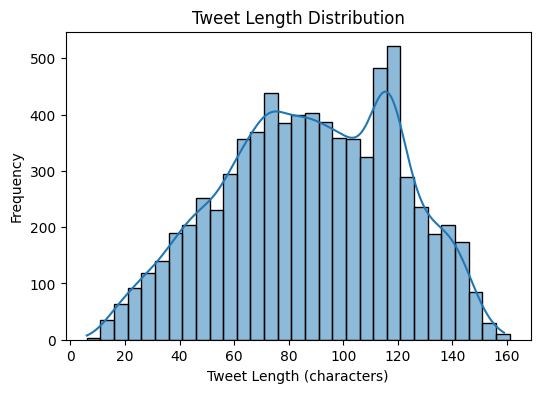

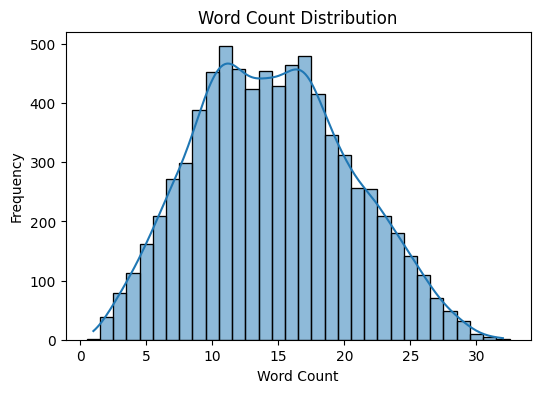

In [2]:
'''
Data pre-processing
'''
hashtag_count = 0
url_count = 0
mentions_count = 0

for tweet in train_df['text']:
    
    if re.search(r'#\w+', tweet):
        hashtag_count += 1
    
   
    if re.search(r'http\S+', tweet):
        url_count += 1
        
    if re.search(r'@\w+', tweet):
        mentions_count += 1

print("\n{} tweets in the training data contain hashtag".format(hashtag_count))
print("\n{} tweets in the training data contain URL".format(url_count))
print("\n{} tweets in the training data contain mentions".format(mentions_count))

processed_train_df = train_df.copy()

def clean_text(text):
    text = re.sub(r"@\w+", "", text)     # Remove @mentions
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"<.*?>", "", text)    # Remove HTML tags
    text = re.sub(r"[^A-Za-z0-9\s]", "", text)  # Remove special chars
    text = re.sub(r"\s+", " ", text)     # Remove extra whitespace
    return text.strip().lower()

processed_train_df["keyword"] = processed_train_df["keyword"].fillna("")
processed_train_df["text"] = processed_train_df["keyword"] + " " + processed_train_df["text"]
processed_train_df["text"] = processed_train_df["text"].apply(clean_text)

train_texts, val_texts, train_labels, val_labels = train_test_split(processed_train_df["text"].tolist(),
                                                                    processed_train_df["target"].tolist(),
                                                                    test_size=0.1,
                                                                    random_state=42)

#Plotting the class distribution in the target
plt.figure(figsize=(6, 4))
processed_train_df['target'].value_counts().plot(kind='bar', color=['blue', 'orange'])

plt.title('Count of 1s and 0s in the "disaster" Column')
plt.xlabel('Disaster Label (0 = Not Disaster, 1 = Disaster)')
plt.ylabel('Count')

plt.xticks([0, 1], ['Not Disaster (0)', 'Disaster (1)'])  # Label x-axis
plt.show()

#Plotting the distribution of tweet length
plt.figure(figsize=(6, 4))
processed_train_df['tweet_length'] = processed_train_df['text'].apply(len)

sns.histplot(processed_train_df['tweet_length'], binwidth=5, kde=True)
plt.title('Tweet Length Distribution')
plt.xlabel('Tweet Length (characters)')
plt.ylabel('Frequency')
plt.show()

#Plotting word count distribution of tweets
plt.figure(figsize=(6, 4))
processed_train_df['word_count'] = processed_train_df['text'].apply(lambda x: len(x.split()))

sns.histplot(processed_train_df['word_count'], discrete=True, kde=True)
plt.title('Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

processed_train_df.drop(columns = ['tweet_length','word_count'], inplace = True)

In [3]:
'''
Fine-tuning a distilbert transformer model to predict disaster
'''
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")

train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)

train_dataset = TensorDataset(train_encodings["input_ids"], train_encodings["attention_mask"], train_labels)
val_dataset = TensorDataset(val_encodings["input_ids"], val_encodings["attention_mask"], val_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# ---------- Model, Optimizer, Scheduler ----------
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
num_training_steps = len(train_loader) * 10  # max epochs (early stopping may stop earlier)
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# ---------- Training and Evaluation ----------
def train_epoch(model, data_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    loop = tqdm(data_loader, desc="Training")
    for batch in loop:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(data_loader)
    acc = sum([p == l for p, l in zip(all_preds, all_labels)]) / len(all_preds)
    f1 = f1_score(all_labels, all_preds)
    return avg_loss, acc, f1

def eval_model(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    loop = tqdm(data_loader, desc="Evaluating")
    with torch.no_grad():
        for batch in loop:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = sum([p == l for p, l in zip(all_preds, all_labels)]) / len(all_preds)
    f1 = f1_score(all_labels, all_preds)
    return acc, f1

# ---------- Training Loop with Early Stopping ----------
EPOCHS = 10
best_f1 = 0
patience = 2
wait = 0

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    
    train_loss, train_acc, train_f1 = train_epoch(model, train_loader, optimizer, lr_scheduler, device)
    val_acc, val_f1 = eval_model(model, val_loader, device)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train F1: {train_f1:.4f}")
    print(f"Val Acc  : {val_acc:.4f} | Val F1  : {val_f1:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        wait = 0
        model.save_pretrained("distilbert-disaster-model")
        tokenizer.save_pretrained("distilbert-disaster-model")
        print("✅ Model improved — saved to 'distilbert-disaster-model'")
    else:
        wait += 1
        print(f"⚠️  No improvement. Early stopping wait: {wait}/{patience}")
        if wait >= patience:
            print("⏹️  Early stopping triggered.")
            break

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]


Epoch 1/10


Evaluating: 100%|██████████| 12/12 [00:01<00:00, 10.85it/s]


Train Loss: 0.4430 | Train Acc: 0.8121 | Train F1: 0.7581
Val Acc  : 0.8163 | Val F1  : 0.7929
✅ Model improved — saved to 'distilbert-disaster-model'

Epoch 2/10


Evaluating: 100%|██████████| 12/12 [00:01<00:00,  8.99it/s]


Train Loss: 0.3494 | Train Acc: 0.8587 | Train F1: 0.8240
Val Acc  : 0.8176 | Val F1  : 0.7583
⚠️  No improvement. Early stopping wait: 1/2

Epoch 3/10


Evaluating: 100%|██████████| 12/12 [00:01<00:00,  9.94it/s]

Train Loss: 0.2966 | Train Acc: 0.8851 | Train F1: 0.8568
Val Acc  : 0.8255 | Val F1  : 0.7879
⚠️  No improvement. Early stopping wait: 2/2
⏹️  Early stopping triggered.


In [4]:
'''
Predicting if a tweet is about a diasater on kaggle test dataset 
'''

# Load the fine-tuned model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("./distilbert-disaster-model")
tokenizer = AutoTokenizer.from_pretrained("./distilbert-disaster-model")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Tokenize the test tweets
kaggle_test_encodings = tokenizer(kaggle_test_df['text'].tolist(),
                                  padding=True,
                                  truncation=True,
                                  max_length=160,
                                  return_tensors="pt")

# Set model to evaluation mode
model.eval()

# Prepare input data
input_ids = kaggle_test_encodings['input_ids'].to(device)
attention_mask = kaggle_test_encodings['attention_mask'].to(device)


# Make predictions
with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    predictions = torch.argmax(outputs.logits, dim=-1)

# Convert predictions to list
predicted_labels = predictions.cpu().numpy()

submission_df = pd.DataFrame({'id': kaggle_test_df['id'],
                              'target': predicted_labels})

# Save to CSV
submission_df.to_csv('submission.csv', index=False)

print("\nBelow is the submission:")
print(submission_df)


Below is the submission:
         id  target
0         0       1
1         2       1
2         3       1
3         9       1
4        11       1
...     ...     ...
3258  10861       1
3259  10865       1
3260  10868       1
3261  10874       1
3262  10875       1

[3263 rows x 2 columns]
